In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import toml
import pandas as pd
import seaborn as sns
import scipy.spatial.transform as tf

from tqdm.auto import tqdm
from scipy import spatial
from sklearn.decomposition import PCA
from scipy.optimize import least_squares

In [4]:
def get_l2_norm(df, x1="kpoint_x", x2="kpoint_com_gauss_x", y1="kpoint_y", y2="kpoint_com_gauss_y"):
    return np.linalg.norm([df[x1] - df[x2], df[y1] - df[y2]])

In [5]:
# https://gist.github.com/davegreenwood/e1d2227d08e24cc4e353d95d0c18c914#file-triangulation-py-L9
# see also https://github.com/opencv/opencv_contrib/blob/master/modules/sfm/src/triangulation.cpp#L96
def triangulate_nviews(P, ip):
    """
    Triangulate a point visible in n camera views.
    P is a list of camera projection matrices.
    ip is a list of homogenised image points. eg [ [x, y, 1], [x, y, 1] ], OR,
    ip is a 2d array - shape nx3 - [ [x, y, 1], [x, y, 1] ]
    len of ip must be the same as len of P
    """
    if not len(ip) == len(P):
        raise ValueError('Number of points and number of cameras not equal.')
    if ip.shape[1] == 2:
        ip = np.hstack([ip, np.ones((len(ip),1), dtype=ip.dtype)])
    n = len(P)
    M = np.zeros([3*n, 4+n])
    for i, (x, p) in enumerate(zip(ip, P)):
        M[3*i:3*i+3, :4] = p
        M[3*i:3*i+3, 4+i] = -x
    try:
        V = np.linalg.svd(M)[-1]
        X = V[-1, :4]
        return X / X[3]
    except np.linalg.LinAlgError as e:
        return np.array([np.nan,np.nan,np.nan])

In [6]:
def triangulate_points(df, extrinsics, min_views=2, use_x="kpoint_com_gauss_x_undistort", use_y="kpoint_com_gauss_y_undistort"):
    input_pts = np.hstack([df[[use_x, use_y]].values, np.ones((len(df),1))])
    cam_matrix = [extrinsics[_cam] for _cam in df["camera"].tolist()]
    if len(cam_matrix)>=min_views:
        return triangulate_nviews(cam_matrix, input_pts)[:3]
    else:
        return np.array([np.nan, np.nan, np.nan])

In [7]:
def pad_matrices(df, kpoint_mapping={}):
    new_arr = np.full((len(kpoint_mapping), 3), fill_value=np.nan, dtype="float")
    for _kpoint_name, _idx in kpoint_mapping.items():
        try:
            new_arr[_idx,:] = df.xs(_kpoint_name, level="kpoint_name").to_numpy()[0]
        except KeyError:
            pass
    return new_arr

In [9]:
def get_plane(points_3d):
    # Suppose `points_3d` is (N, 3)
    pca = PCA(n_components=3)
    centroid = np.nanmean(points_3d, axis=0)
    pca.fit(points_3d - centroid)
    z_axis = np.array([0, 0, 1])
    normal = pca.components_[2]  # Normal vector
    rotation_vec = np.cross(normal, z_axis)
    rotation_angle = np.arccos(np.clip(np.dot(normal, z_axis), -1, 1))
    if np.linalg.norm(rotation_vec) > 1e-6:
        rotation_vec /= np.linalg.norm(rotation_vec)
        rot = tf.Rotation.from_rotvec(rotation_angle * rotation_vec)
        # points_aligned = rot.apply(points_3d)
    else:
        # points_aligned = points_3d
        rot = None
    return rot, centroid

In [45]:
def compute_camera_geometry(X, C, arena_center):
    """
    X: (..., 3) keypoints
    C: (3,) camera position
    arena_center: (3,) target the camera is looking at
    Returns: distance (...), angle_deg (...)
    """
    V_to_point = X - C
    V_target = arena_center - C

    dist = np.linalg.norm(V_to_point, axis=-1)

    # Normalize
    V_to_point_norm = V_to_point / np.linalg.norm(V_to_point, axis=-1, keepdims=True)
    V_target_norm = V_target / np.linalg.norm(V_target)

    dot = np.sum(V_to_point_norm * V_target_norm, axis=-1)
    angle_rad = np.arccos(np.clip(dot, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    return dist, angle_deg

## Gather data and predicted keypoints

In [11]:
centroid_parts = [
    "foreleg_L",
    "foreleg_R",
    "hindleg_L",
    "hindleg_R",
    "back_bottom",
    "back_middle",
    "back_top",
]

In [12]:
import socket
hostname = socket.gethostname()

config = toml.load("../preprocessing/config.toml")
if "pace" in hostname:
    save_dir = config["dirs"]["analysis"]
else:
    save_dir = os.path.expanduser("~/Desktop/data/qds_sciadv_rebuttal/quantum_dot_analysis/")

use_joints = False

In [13]:
if use_joints:
    save_file = os.path.join(save_dir, "kpoint_training_dataset_qd_alignment_kneejoints_reflect_only_round2_manual_labeling_nofluo_version-v1.parquet") 
else:
    # save_file = "/storage/coda1/p-jmarkowitz30/0/shared/active_lab_members/markowitz_jeffrey/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels_qd/kpoint_training_dataset_qd_alignment_round2_manual_labeling_nofluo_version-v1.parquet"
    save_file = os.path.join(save_dir, "kpoint_training_dataset_qd_alignment_round2_manual_labeling_nofluo_version-v1.parquet")     

In [14]:
min_nviews = 2

In [15]:
# also here drop keypoints that we can't triangulate...
qd_df = pd.read_parquet(save_file).drop(["crop_im"],axis=1)
qd_df["session"] = qd_df["kpoint_avi_fname"].str.extract("(session_[0-9|\-]+) ")
qd_df = qd_df.groupby(["session","frame_index","kpoint_name"]).filter(lambda x: len(x["kpoint_x"].dropna()) >= min_nviews)

In [16]:
qd_df.index = np.arange(len(qd_df))

In [17]:
# map to idx 
kpoint_idx_mapping = {key: i for i, key in enumerate(sorted(qd_df["kpoint_name"].unique()))}
idx_kpoint_mapping = {v: k for k, v in kpoint_idx_mapping.items()}

In [18]:
qd_df["kpoint_idx"] = qd_df["kpoint_name"].map(kpoint_idx_mapping)


# Threshold data

In [19]:
score_threshold = .5

In [20]:
sessions = qd_df["session"].unique()

In [21]:
# filtered_qd_df = qd_df.query("kpoint_score > @score_threshold").copy()
filtered_qd_df = qd_df

# load in calibration

In [22]:
cam_path = os.path.join("/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/timecourse_02_calibration_v2.toml")
# cam_path = os.path.expanduser(os.path.join(save_dir, "timecourse_02_calibration_v2.toml"))
projection_m = toml.load(cam_path)

In [23]:
cams = list(projection_m["extrinsics"].keys())

In [24]:
extrinsics = {}
intrinsics = {}
distortion_coeffs = {}

for k, v in projection_m["extrinsics"].items():
    extrinsics[k] = np.array(v)

for k, v in projection_m["intrinsics"].items():
    intrinsics[k] = np.array(v)
    
for k, v in projection_m["distortion_coeffs"].items():
    distortion_coeffs[k] = np.array(v)

In [25]:
tqdm.pandas()

In [26]:
undistorted_points = filtered_qd_df.groupby("camera")[
    ["camera", "kpoint_com_gauss_x", "kpoint_com_gauss_y"]
].progress_apply(
    lambda x: (
        pd.DataFrame(
        data=cv2.undistortPoints(
        x[["kpoint_com_gauss_x", "kpoint_com_gauss_y"]].values,
        intrinsics[x["camera"].iat[0]],
        distortion_coeffs[x["camera"].iat[0]]
        ).squeeze(),
        columns=["kpoint_com_gauss_x_undistort","kpoint_com_gauss_y_undistort"],
        index=x.index,
)))

undistorted_points.index = undistorted_points.index.get_level_values(-1)
filtered_qd_df = filtered_qd_df.join(undistorted_points)

undistorted_points = filtered_qd_df.groupby("camera")[
    ["camera", "kpoint_x", "kpoint_y"]
].progress_apply(
    lambda x: (
        pd.DataFrame(
        data=cv2.undistortPoints(
        x[["kpoint_x", "kpoint_y"]].values,
        intrinsics[x["camera"].iat[0]],
        distortion_coeffs[x["camera"].iat[0]]
        ).squeeze(),
        columns=["kpoint_x_undistort","kpoint_y_undistort"],
        index=x.index,
)))

undistorted_points.index = undistorted_points.index.get_level_values(-1)
filtered_qd_df = filtered_qd_df.join(undistorted_points)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# we also need undistorted in pixel coordinates to compute errors (don't use for triangulation)...
undistorted_points_unnormalized = filtered_qd_df.groupby("camera")[
    ["camera", "kpoint_com_gauss_x", "kpoint_com_gauss_y"]
].progress_apply(
    lambda x: (
        pd.DataFrame(
        data=cv2.undistortPoints(
        x[["kpoint_com_gauss_x", "kpoint_com_gauss_y"]].values,
        intrinsics[x["camera"].iat[0]],
        distortion_coeffs[x["camera"].iat[0]],
        P=intrinsics[x["camera"].iat[0]],
        ).squeeze(),
        columns=["kpoint_com_gauss_x_undistort_pixel","kpoint_com_gauss_y_undistort_pixel"],
        index=x.index,
)))

undistorted_points_unnormalized.index = undistorted_points_unnormalized.index.get_level_values(-1)
filtered_qd_df = filtered_qd_df.join(undistorted_points_unnormalized)

undistorted_points_unnormalized = filtered_qd_df.groupby("camera")[
    ["camera", "kpoint_x", "kpoint_y"]
].progress_apply(
    lambda x: (
        pd.DataFrame(
        data=cv2.undistortPoints(
        x[["kpoint_x", "kpoint_y"]].values,
        intrinsics[x["camera"].iat[0]],
        distortion_coeffs[x["camera"].iat[0]],
        P=intrinsics[x["camera"].iat[0]],
        ).squeeze(),
        columns=["kpoint_x_undistort_pixel","kpoint_y_undistort_pixel"],
        index=x.index,
)))

undistorted_points_unnormalized.index = undistorted_points_unnormalized.index.get_level_values(-1)
filtered_qd_df = filtered_qd_df.join(undistorted_points_unnormalized)

In [27]:
kpoints = list(kpoint_idx_mapping.keys())
cameras = list(extrinsics.keys())
nframes = len(filtered_qd_df.drop_duplicates(["session","frame_index"]))

In [28]:
pts_com = (
    filtered_qd_df
    .groupby(["session","frame_index","kpoint_name"])[
        ["kpoint_com_gauss_x_undistort", "kpoint_com_gauss_y_undistort", "camera"]
    ]
    .progress_apply(lambda x: triangulate_points(x, extrinsics=extrinsics, min_views=min_nviews))
)
padded_pts_com = (
    pts_com
    .groupby(["session", "frame_index"])
    .progress_apply(lambda x: pad_matrices(x, kpoint_mapping=kpoint_idx_mapping))
)

  0%|          | 0/995140 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/99514 [00:00<?, ?it/s]

In [29]:
pts_kpoint = filtered_qd_df.groupby(["session", "frame_index", "kpoint_name"])[
    ["kpoint_x_undistort", "kpoint_y_undistort", "camera"]
].progress_apply(
    lambda x: triangulate_points(
        x, extrinsics=extrinsics, min_views=min_nviews, use_x="kpoint_x_undistort", use_y="kpoint_y_undistort"
    )
)
padded_pts_kpoint = pts_kpoint.groupby(["session", "frame_index"]).progress_apply(
    lambda x: pad_matrices(x, kpoint_mapping=kpoint_idx_mapping)
)

  0%|          | 0/995140 [00:00<?, ?it/s]

  0%|          | 0/99514 [00:00<?, ?it/s]

IOStream.flush timed out


# now take the triangulated data and package

In [30]:
permute = [0, 2, 1]
flip_z = True

In [31]:
# centroid parts
centroid_idx = sorted([kpoint_idx_mapping[_part] for _part in centroid_parts])
centroid_3d_com = padded_pts_com.progress_apply(lambda x: np.nanmedian(x[centroid_idx,:],axis=0))
centroid_3d_kpoint = padded_pts_kpoint.progress_apply(lambda x: np.nanmedian(x[centroid_idx,:],axis=0))
xyz_com = np.stack(centroid_3d_com)
xyz_com = xyz_com[:,permute]
xyz_kpoint = np.stack(centroid_3d_kpoint)
xyz_kpoint = xyz_kpoint[:,permute]
if flip_z:
    xyz_com[:,2] *= -1
    xyz_kpoint[:,2] *= -1
print("X range:", np.nanmin(xyz_com[:,0]), np.nanmax(xyz_com[:,0]))
print("Y range:", np.nanmin(xyz_com[:,1]), np.nanmax(xyz_com[:,1]))
print("Z range:", np.nanmin(xyz_com[:,2]), np.nanmax(xyz_com[:,2]))

  0%|          | 0/99514 [00:00<?, ?it/s]

/tmp/ipykernel_3227157/399689187.py:3: RuntimeWarning: All-NaN slice encountered
  centroid_3d_com = padded_pts_com.progress_apply(lambda x: np.nanmedian(x[centroid_idx,:],axis=0))


  0%|          | 0/99514 [00:00<?, ?it/s]

X range: -203.0369933368354 145.7882548021557
Y range: 203.0641648637491 541.4403676497175
Z range: -68.4834556287769 68.83223486963605


In [32]:
camera_pos = {}
for _cam, _extrinsic in extrinsics.items():
    # Extract R and t
    R = _extrinsic[:, :3]
    t = _extrinsic[:, 3:] 
    # Compute camera center in world coordinates
    camera_pos[_cam]= -R.T @ t

In [33]:
permute

[0, 2, 1]

In [34]:
for k, v in camera_pos.items():
    camera_pos[k] = v[permute]
    if flip_z:
        camera_pos[k][-1] *= - 1

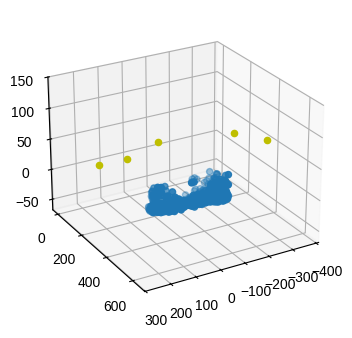

In [35]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    xyz_kpoint[:10000:10,0],
    xyz_kpoint[:10000:10,1],
    xyz_kpoint[:10000:10,2],
    lw=1,
    # color=palette[_notes],
)
for k, v in camera_pos.items():
    ax.scatter(v[0], v[1], v[2], color="y")
elev = 25
azim = +60
ax.view_init(elev, azim)

In [36]:
# use z_depths close and far...

# Make sure everything lies on a plane, re-triangulate with corrected camera positions

In [37]:
import copy
# flip_z = True

In [38]:
# subsample for rotation
use_xyz_com = xyz_com.copy()
use_xyz_com = use_xyz_com[~np.isnan(use_xyz_com).any(axis=1)]
rot_3d, centroid = get_plane(use_xyz_com)

In [39]:
new_xyz_com = rot_3d.apply(xyz_com - centroid)
new_xyz_kpoint = rot_3d.apply(xyz_kpoint - centroid)

In [40]:
corrected_camera_pos = copy.deepcopy(camera_pos)
for k, v in corrected_camera_pos.items():
    use_v = v
    new_v = rot_3d.apply(use_v.ravel() - centroid)
    corrected_camera_pos[k] = new_v

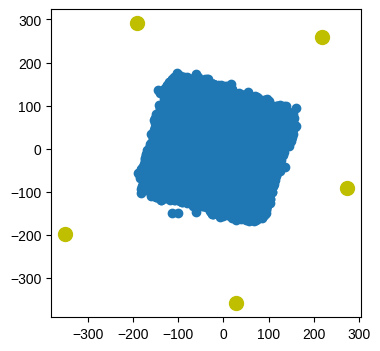

In [42]:
fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(xyz_com[:,0],
           xyz_com[:,1])
for k, v in corrected_camera_pos.items():
    ax.scatter(v[0], v[1], color="y", s=100)

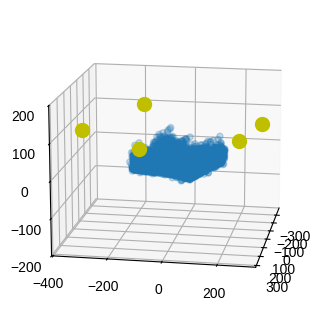

In [43]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    new_xyz_com[::5,0],
    new_xyz_com[::5,1],
    new_xyz_com[::5,2],
    alpha=.25,
    # lw=1,
    # color=palette[_notes],
)
for k, v in corrected_camera_pos.items():
    ax.scatter(v[0], v[1], v[2], color="y", s=100)
ax.set(zlim=(-200,200))

elev = +15
azim = +10
ax.view_init(elev, azim)

In [44]:
sessions = padded_pts_com.index.get_level_values(0).unique()

In [46]:
arena_center = np.nanmedian(new_xyz_com, axis=0)

In [47]:
pts_index = list(padded_pts_com.index)

In [49]:
cameras = list(extrinsics.keys())
dfs = []
for chk_camera in tqdm(cameras):
    dist, angle = compute_camera_geometry(new_xyz_com, corrected_camera_pos[chk_camera].ravel(), arena_center=arena_center) 
    new_index = [(_session, _frame_index, chk_camera) for _session, _frame_index in pts_index]
    _geometry_df = pd.DataFrame()
    _geometry_df.index = pd.MultiIndex.from_tuples(new_index)
    _geometry_df.index.names = ["session","frame_index","camera"]
    _geometry_df["dist_from_camera_mm"] = dist
    _geometry_df["angle_from_camera_degrees"] = angle
    dfs.append(_geometry_df)

  0%|          | 0/5 [00:00<?, ?it/s]

In [85]:
geometry_df = pd.concat(dfs, ignore_index=False)

In [110]:
new_df = pd.merge(filtered_qd_df, geometry_df, on=list(geometry_df.index.names))

In [111]:
new_df["error_kpoint_x_px"] = new_df["kpoint_x_undistort_pixel"] - new_df["kpoint_com_gauss_x_undistort_pixel"]
new_df["error_kpoint_y_px"] = new_df["kpoint_y_undistort_pixel"] - new_df["kpoint_com_gauss_y_undistort_pixel"]

fx_map = {_cam: v[0,0] for _cam, v in intrinsics.items()}
fy_map = {_cam: v[1,1] for _cam, v in intrinsics.items()}
px_map = {_cam: v[0,2] for _cam, v in intrinsics.items()}
py_map = {_cam: v[1,2] for _cam, v in intrinsics.items()}

new_df["fx"] = new_df["camera"].map(fx_map)
new_df["fy"] = new_df["camera"].map(fy_map)
new_df["px"] = new_df["camera"].map(px_map)
new_df["py"] = new_df["camera"].map(py_map)

new_df["error_kpoint_x_mm"] = (new_df["error_kpoint_x_px"] * new_df["dist_from_camera_mm"]) / new_df["px"]
new_df["error_kpoint_y_mm"] = (new_df["error_kpoint_y_px"] * new_df["dist_from_camera_mm"]) / new_df["py"]
new_df["error_kpoint_l2_mm"] = np.hypot(new_df["error_kpoint_x_mm"], new_df["error_kpoint_y_mm"])

In [112]:
xyz_df = pd.DataFrame(data=new_xyz_com, index=padded_pts_com.index, columns=["centroid_x_world","centroid_y_world","centroid_z_world"])
new_df = pd.merge(new_df, xyz_df, on=list(xyz_df.index.names))

In [113]:
cam_df = pd.DataFrame(data=np.stack(list(corrected_camera_pos.values())), index=list(corrected_camera_pos.keys()), columns=["camera_x_world","camera_y_world","camera_z_world"])
cam_df.index.name = "camera"

In [114]:
new_df = pd.merge(new_df, cam_df, on=list(cam_df.index.names))

In [115]:
new_df.to_parquet(os.path.join(save_dir, "accuracy_v_distance_from_camera.parquet"))